In [4]:
import math
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.optimize as sp_op
from tqdm import tqdm 

import mosek.fusion as mos


In [5]:
def raw_convert(data:pd.DataFrame,period:int,export = False):
    # convert raw input data into data that samples once every x ticks
    # data      : pd.DataFrame  - Input Raw Data
    # period    : int           - sampling period 
    # return    : pd.DataFrame  - the sampled DataFrame 

    sval = period
    out = []
    for i in tqdm(range(0,data.shape[0])):
        sval -= data.iloc[i,1]
        while sval <=0: 
            out.append(data.iloc[i,0])
            sval+=period
    if export:
        out = pd.DataFrame(out,columns=["last"])
        fp = Path('nptdata.csv')  
        fp.parent.mkdir(parents=True, exist_ok=True)  
        out.to_csv(fp)
    return out

def get_ret(data:pd.DataFrame,period:int=1):
    # get n period retruns 
    # data      : pd.DataFrame  - Input Raw Data
    # period    : int           - sampling period 
    # return    : pd.DataFrame  - the sampled DataFrame 

    ret =  (data-data.shift(period))/data.shift(period)
    return ret

rawdata = pd.read_csv("hsiapr_1tick.csv")
rawdata.columns = ["last","number"]
outdata = raw_convert(rawdata,10)

100%|██████████| 776966/776966 [00:34<00:00, 22820.16it/s]


In [6]:
ptdata = pd.read_csv("nptdata.csv")
ptdata = ptdata["last"]

ret = pd.DataFrame()
ret["Ret"] = get_ret(ptdata)
ret.dropna(inplace=True)

In [16]:
class data:
    # Main data object 
    # allows one target data set be applied on by multiple prediective factor set and models

    def __init__(self, data: pd.DataFrame, x: list = None, y: str = "Ret") -> None:
        # Initalise Data Object
        # data      : pd.DataFrame  - Input Raw Data
        # x         : [str]         - Column Names for factor sets 
        # y         : str           - Column Name for target data set

        self.datain = data 
        self.y_vec = y
        self.x_vecs = x

        #initialisation
        self.x = dict()
        self.y = dict()
        self.yhat = dict()
        
        # list of models used
        self.models_used = dict()
        self.models_status = dict()

        self.fignum=1

    # split up data seqequence into multiple segments
    def split(self, periods: dict = {"train": 0.6,"test": 0.4}):
        # Split Up data into mutliple period, for training, Cross-Validation, Testing etc.
        # periods   : dict{ Period Name: Fraction}  - Name for a Period or split, 
        #               Fraction is the Fraction of the whole data set in the period or split
        #               "Train": 0.5 => 50% of total data in "Train" Data Set,
        #               All Fractions MUST sum to 1

        po = 0
        valo = 0
        for period in periods.keys():
            self.x[period] = dict()
            self.yhat[period] = dict()
            pn = po + periods[period]
            valn = round(pn*self.datain.shape[0])
            if pn == 1:
                self.y[period] = (self.datain[self.y_vec].iloc[valo:])
            else:
                self.y[period] = (self.datain[self.y_vec].iloc[valo:valn])
            po = pn
            valo = valn

    def eval_all(self,period:str = "train"):
        # Evaluate/ Backtest all sucessfully trained Models 
        # periods   : str     - Name of Period to Backtest, 

        for model in self.models_used.keys():
            if self.models_status[model]:
                self.models_used[model].predict(period)
                self.models_used[model].eval(period)
    
class Model:
    # empty interface class for any model

    def __init__(self) -> None:
        pass
    def create_x():
        pass
    def train():
       pass
    def crossval():
        pass
    def eval(self,period:str): 
        pass


class EWA_Model_1f(Model):
    # Model class for the exponential weighted average model (1 factor)

    def __init__(self,data:data,name:str = None) -> None:
        # initiate an instance of the EWA-1Factor Model        
        # data   : data     - passes a data object, the data for the model to apply to
        # name   : str      - name of the model instance, if there's no name a defualt is used
        #                   Model names MUST be unique
        self.data = data
        
        if name:
            self.name = name
        else: 
            self.name = "EWA_Model_1f"      

        data.models_used[self.name]=self
        data.models_status[self.name]=False
    
    def eval_loss_func(self, sqers, lbd, v0):
        # evaluate the loss function given data, lambda and intial volatility
        # sqers  : pd.DataFrame     - squared error 
        # v0     : float            - intial volatility term
        # lbd    : float            - lambda (training parameter)
        # return : float            - the evaluated log likihood
        vo = v0
        sqero = sqers.iloc[0]
        lossfunc = self.eval_single_loss(sqers.iloc[0],v0)
        vol = [v0]
        
        for sqer in tqdm(sqers.iloc[1:]) :
            
            # find current vol estimate
            vn = (1-lbd)*sqero+lbd*vo
            # eval loss for vol
            lossfunc += self.eval_single_loss(sqer,vn)
            #record estimated vol
            vol += [vn]
            # update 
            vo=vn
            sqero = sqer

        self.lossfuncval = lossfunc
        self.volhat = pd.DataFrame(vol,index=sqers.index,columns = ["vol"])
        return lossfunc

    def eval_single_loss(self,sqer,v):
        # evaluate a single loss function given data
        # private method

        if v<0: v=1e-20
        return math.log(v)+sqer/v
    
    def train(self,period:str="train"):
        # calls Scipy Optimiser to train the model
        # period : str     - the period to train the model on 

        mu, sqers, v0 = self.create_x(period)
    
        self.opt_res = sp_op.minimize_scalar(
            lambda l: self.eval_loss_func(lbd = l, sqers = sqers, v0 = v0),
            method = "bounded",
            bounds =(0,1),
            options={
                "maxiter" :  5000,
                "xatol" :  1e-12  
            })
        
        self.predict("train")
        print(self.opt_res)

        if self.opt_res["message"]=="Solution found.":
            self.data.models_status[self.name]=True
    
    def create_x(self, period:str):
        # generates and store all pre-requisites data and objects for the model to be trained or used 
        # period        : str           - the period to generate the pre-requisite
        # retrun (mu)   : float         - period mean
        # retrun (sqers): pd.DataFrame  - squared error 
        # retrun (v0)   : float         - intial volatility
         
        tdata = self.data.y[period]

        mu = tdata.mean()
        sqers = (tdata-mu)**2
        v0 = (tdata.iloc[0]-mu)**2
        x  = (mu,sqers,v0)
        
        self.data.x[period][self.name]=x

        return mu,sqers,v0

    def predict(self,period:str = "test"):
        # use a trained model to predict volatility for the period 
        # period        : str           - the period to predict

        lbest = self.opt_res["x"]
        mu, sqers, v0 = self.create_x(period)
        self.eval_loss_func(lbd=lbest,sqers=sqers,v0=v0)

        self.data.yhat[period][self.name] = self.volhat
    
    def eval(self,period:str = "test"):
        # Evaluate/ Backtest and visualise the model performance on the period
        # period        : str           - the period to evaluate/ backtest        

        plt.figure(self.data.fignum)
        self.data.fignum+=1

        mu = self.data.x[period][self.name][0]
        vhat = self.data.yhat[period][self.name]
        y = pd.DataFrame(self.data.y[period])
        stdval = (mu+vhat**0.5).rename(columns = {"vol": "Ret"})
        less_than_1std = (abs(y)<=stdval).sum()*100/y.shape[0]

        one_std_upper = plt.plot(mu+vhat**0.5,'b', label = "1-std CI")
        one_std_lower = plt.plot(mu-vhat**0.5,'b')

        actual = plt.plot(y,'g',alpha = 0.5, label = "actual")

        three_std_upper = plt.plot(mu+3*vhat**0.5,'r', label = "3-std CI")
        three_std_lower = plt.plot(mu-3*vhat**0.5,'r')

        plt.xlabel("sample points \n {}% of samples within 1 std".format(round(less_than_1std.values[0],1)))
        plt.ylabel("returns")
        plt.title("predicted return Intervals vs observed returns: {} period".format(period))

        plt.legend()
        plt.show()
         
class GarchPQ (EWA_Model_1f):
# Failed Implementation of a Garch PQ Model 
# inherited From the EWA_Model_1f, see the relavent documentations
    
# calls Scipy "trust-constr" solver, numerical issues encountered
        
    def __init__(self,data:data,name:str = None, P:int = 1, Q: int = 1) -> None:
        self.data = data
        self.P = P
        self.Q = Q

        if name:
            self.name = name
        else: 
            self.name = "Garch{}{}".format      

        data.models_used[self.name]=self
        data.models_status[self.name]=False
    
    def eval_loss_func(self, theta, sqers, v0):
        # Need to Debug #
        pvec = theta[:self.P]
        qvec = theta[self.P:theta.shape[0]-1]
        c = theta[-1]

        vol = pd.Series(0,range(0,sqers.shape[0]))
        vol.iloc[0:v0.shape[0]]=v0
        lossfunc=0

        sqero = np.ndarray(self.P)
        volo = np.ndarray(self.Q)
        volo = list()
        if self.P > self.Q:
            sqero[:] = sqers.iloc[:self.P]
        else:
            sqero[:] = sqers.iloc[self.Q-self.P:self.Q]
        volo[:] = v0

        sqero = np.flip(sqero)
        volo = np.flip(volo)
        i = max(self.P,self.Q)

        for sqer in tqdm(sqers.iloc[i:]) :
            # find current vol estimate
            vn=0
            vn += pvec.dot(sqero.T)
            vn += qvec.dot(volo.T)
            vn += c

            # eval loss for vol
            lossfunc += self.eval_single_loss(sqer,vn)
            #record estimated vol

            # update
            sqero = np.roll(sqero,1)
            sqero[0]=sqer
            
            volo = np.roll(volo,1)
            volo[0]=vn
            vol.iat[i]=vn

            i+=1
           
        vol.index=sqers.index
        self.lossfuncval = lossfunc
        self.volhat = vol
        return lossfunc

    def eval_jac(self,theta, sqers, vol):
        g = vol**-1*sqers*(vol**-2)
        L = theta.shape[0]

        jacvec = np.zeros(theta.shape)
        for i in range(0,self.P):
            t=g*sqers.shift(i+1)
            jacvec[i]=t.sum()
        for j in range(self.P,L-1):
            t=g*vol.shift(j+1-self.P)
            jacvec[j]=t.sum()
        
        return jacvec
    def eval_hess(self,theta, sqers, vol):
        g = vol**-1*sqers*(vol**-2)
        h = -vol**-2+2*sqers*(vol**-3)
        L = theta.shape[0]

        hess = np.zeros([L,L])
        for i in range(0,self.P):
            for m in range(0,self.P):
                t = h*sqers.shift(i+1)*sqers.shift(m+1)
                hess[i,m]=t.sum()
            for n in range(self.P,L-1):
                t = h*sqers.shift(i+1)*vol.shift(n+1-self.P)
                hess[i,n]=t.sum()
        for j in range(self.P,L-1):
            for m in range(0,self.P):
                t = h*sqers.shift(m+1)*vol.shift(j+1-self.P)+g*sqers.shift(j+m+1-self.P)
                hess[j,m]=t.sum()
            for n in range(self.P,L-1):
                t = h*vol.shift(j+1-self.P)*vol.shift(n+1-self.P)+g*vol.shift(j+n+1-2*self.P)
                hess[j,n]=t.sum()
        return hess

    def train(self,period:str="train", maxiter = 500):
        # Need to Rework #
        mu, sqers, v0, theta0 = self.create_x(period, a = 0.8)
        theta0 = theta0.squeeze()
        for i in range(0,theta0.shape[0]):
            if theta0[i] < 0:
                theta0[i] = 0
        
        # Constraints
        probA = np.ones([1,len(theta0)])
        problb = np.zeros(theta0.shape)
        probub = np.ones(theta0.shape)

        # call optimiser
        self.opt_res=sp_op.minimize(
            # method = "SLSQP",
            method = "trust-constr",
            fun = lambda theta: self.eval_loss_func(theta,sqers=sqers,v0=v0),
            x0 = theta0,
            jac = lambda theta: self.eval_jac(theta,sqers = sqers, vol=self.volhat),
            hess = lambda theta: self.eval_hess(theta, sqers = sqers, vol = self.volhat),
            bounds = sp_op.Bounds(lb = problb, ub = probub),
            constraints= sp_op.LinearConstraint(A =probA, lb = 0, ub=1),
            options = {
                "maxiter":maxiter,
                "verbose":3
            }
        )

        self.predict("train")
        print(self.opt_res)

        if self.opt_res["success"]=="Solution found." or self.opt_res["message"]=='The maximum number of function evaluations is exceeded.':
            self.data.models_status[self.name]=True
   
    def create_x(self, period:str, a = 0.99):
        # Generate estimations
        tdata = self.data.y[period]

        mu = tdata.mean()
        vol = tdata.var()
        sqers = (tdata-mu)**2

        if self.P > self.Q:
            v0 = sqers.iloc[self.P-self.Q:self.P]
        else:
            v0 = sqers.iloc[:self.Q]

        # finding intial guess (estimating assuming v_t = E(v), and Sum(Q)+Sum(P)=1)
        Mp = pd.DataFrame(index= sqers.index, columns = range(0,self.P))
        for i in range(1,self.P+1): 
            Mp.iloc[:,i-1] = sqers.shift(i)
        Mpones = pd.DataFrame(1,sqers.index,range(0,self.P))
        
        A = (Mp - vol*Mpones).dropna()
        b = pd.DataFrame(1,A.index,[0])
        N = A.T.dot(A)
        N_inv = pd.DataFrame(np.linalg.pinv(N.values),N.index,N.columns)
        p0 = N_inv.dot(A.T.dot(b))
        
        v_ones_Q1 =pd.DataFrame(1,range(0,self.Q),[0])
        M_ones_QQ = pd.DataFrame(1, range(0,self.Q), range(0,self.Q))
        M_ones_QP = pd.DataFrame(1,range(0,self.Q),range(0,self.P))
        M_ones_QQ_inv = pd.DataFrame(np.linalg.pinv(M_ones_QQ.values),M_ones_QQ.index,M_ones_QQ.columns)
        
        q0 = M_ones_QQ_inv.dot(v_ones_Q1)*a- M_ones_QQ_inv.dot(M_ones_QP).dot(p0)
        theta0 = p0.append(q0).append([0]).values

        x = (mu,sqers,v0,theta0)
        
        self.data.x[period][self.name]=x
        
        return mu,sqers,v0,theta0

    def predict(self,period:str = "test"):
        thetabest = self.opt_res["x"]
        mu, sqers, v0, theta0 = self.create_x(period)
        self.eval_loss_func(theta=thetabest,sqers=sqers,v0=v0)

        self.data.yhat[period][self.name] = pd.DataFrame(self.volhat,sqers.index,['vol'])


In [17]:
ptdata = pd.read_csv("nptdata.csv")
ptdata = ptdata["last"]

ret = pd.DataFrame()
ret["Ret"] = get_ret(ptdata)
ret.dropna(inplace=True)

retdata = data(ret)
retdata.split()
vol_model = EWA_Model_1f(retdata,"EWA")
vol_model.train()
vol_model.predict("test")



  0%|          | 0/78084 [00:00<?, ?it/s]

100%|██████████| 78084/78084 [00:00<00:00, 266247.00it/s]


     fun: -965263.7894132726
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 0.9994506856310927


100%|██████████| 52056/52056 [00:00<00:00, 138597.64it/s]


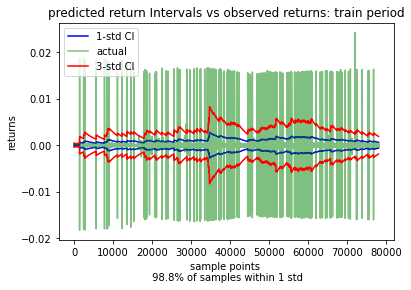

In [18]:
# evaluate the performance of the model for the testing period
vol_model.eval("train")


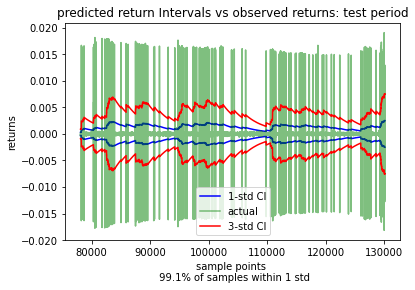

In [19]:
# evaluate the performance of the model for the training period
vol_model.eval("test")


In [20]:
## Fail Implementation of Garch PQ

Garch_model = GarchPQ(retdata,"Garch",P=2,Q=4)
Garch_model.train(maxiter=100)

100%|██████████| 78081/78081 [00:04<00:00, 17704.90it/s]


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +1.1375e+07 | 1.00e+00 | 6.38e+15 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |


100%|██████████| 78081/78081 [00:04<00:00, 17547.36it/s]


|   2   |   2   |   1   | +1.1375e+07 | 5.00e-01 | 6.38e+15 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16929.10it/s]


|   3   |   3   |   2   | +1.1375e+07 | 2.50e-01 | 6.38e+15 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14681.18it/s]


|   4   |   4   |   3   | +1.1375e+07 | 1.25e-01 | 6.38e+15 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14036.31it/s]


|   5   |   5   |   4   | -1.9347e+05 | 1.25e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17275.28it/s]


|   6   |   6   |   5   | -1.9347e+05 | 6.25e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16453.88it/s]


|   7   |   7   |   6   | -1.9347e+05 | 3.12e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16663.10it/s]


|   8   |   8   |   7   | -1.9347e+05 | 1.56e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13372.71it/s]


|   9   |   9   |   8   | -1.9347e+05 | 7.81e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18209.64it/s]


|  10   |  10   |   9   | -1.9347e+05 | 3.91e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18771.59it/s]


|  11   |  11   |  10   | -1.9347e+05 | 1.95e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15871.86it/s]


|  12   |  12   |  11   | -1.9347e+05 | 9.77e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13630.40it/s]


|  13   |  13   |  12   | -1.9347e+05 | 4.88e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 19498.88it/s]


|  14   |  14   |  13   | -1.9347e+05 | 2.44e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18422.29it/s]


|  15   |  15   |  14   | -1.9347e+05 | 1.22e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18765.35it/s]


|  16   |  16   |  15   | -1.9347e+05 | 6.10e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15381.36it/s]


|  17   |  17   |  16   | -1.9347e+05 | 3.05e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17068.63it/s]


|  18   |  18   |  17   | -1.9347e+05 | 1.53e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 19474.26it/s]


|  19   |  19   |  18   | -1.9347e+05 | 7.63e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15731.89it/s]


|  20   |  20   |  19   | -1.9347e+05 | 3.81e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14611.57it/s]


|  21   |  21   |  20   | -1.9347e+05 | 1.91e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16620.33it/s]


|  22   |  22   |  21   | -1.9347e+05 | 9.54e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18118.59it/s]


|  23   |  23   |  22   | -1.9347e+05 | 4.77e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:03<00:00, 19864.62it/s]


|  24   |  24   |  23   | -1.9347e+05 | 2.38e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:03<00:00, 20359.77it/s]


|  25   |  25   |  24   | -1.9347e+05 | 1.19e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18063.14it/s]


|  26   |  26   |  25   | -1.9347e+05 | 5.96e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15114.70it/s]


|  27   |  27   |  26   | -1.9347e+05 | 2.98e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13787.82it/s]


|  28   |  28   |  27   | -1.9347e+05 | 1.49e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18667.08it/s]


|  29   |  29   |  28   | -1.9347e+05 | 7.45e-09 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


100%|██████████| 78081/78081 [00:03<00:00, 19921.16it/s]


|  30   |  30   |  28   | -1.9347e+05 | 1.00e+00 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   0   |


100%|██████████| 78081/78081 [00:04<00:00, 16759.70it/s]


|  31   |  31   |  29   | -1.9347e+05 | 5.00e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14571.77it/s]


|  32   |  32   |  30   | -1.9347e+05 | 2.50e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17923.28it/s]


|  33   |  33   |  31   | -1.9347e+05 | 1.25e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11879.27it/s]


|  34   |  34   |  32   | -1.9347e+05 | 6.25e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16623.62it/s]


|  35   |  35   |  33   | -1.9347e+05 | 3.12e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16867.38it/s]


|  36   |  36   |  34   | -1.9347e+05 | 1.56e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18592.09it/s]


|  37   |  37   |  35   | -1.9347e+05 | 7.81e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16597.62it/s]


|  38   |  38   |  36   | -1.9347e+05 | 3.91e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15843.50it/s]


|  39   |  39   |  37   | -1.9347e+05 | 1.95e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14412.74it/s]


|  40   |  40   |  38   | -1.9347e+05 | 9.77e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18284.72it/s]


|  41   |  41   |  39   | -1.9347e+05 | 4.88e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15879.58it/s]


|  42   |  42   |  40   | -1.9347e+05 | 2.44e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:03<00:00, 19684.11it/s]


|  43   |  43   |  41   | -1.9347e+05 | 1.22e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14046.39it/s]


|  44   |  44   |  42   | -1.9347e+05 | 6.10e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13533.93it/s]


|  45   |  45   |  43   | -1.9347e+05 | 3.05e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16401.47it/s]


|  46   |  46   |  44   | -1.9347e+05 | 1.53e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16150.24it/s]


|  47   |  47   |  45   | -1.9347e+05 | 7.63e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16453.05it/s]


|  48   |  48   |  46   | -1.9347e+05 | 3.81e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16041.68it/s]


|  49   |  49   |  47   | -1.9347e+05 | 1.91e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17416.19it/s]


|  50   |  50   |  48   | -1.9347e+05 | 9.54e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 19089.47it/s]


|  51   |  51   |  49   | -1.9347e+05 | 4.77e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 19147.61it/s]


|  52   |  52   |  50   | -1.9347e+05 | 2.38e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13271.14it/s]


|  53   |  53   |  51   | -1.9347e+05 | 1.19e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13261.21it/s]


|  54   |  54   |  52   | -1.9347e+05 | 5.96e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18216.70it/s]


|  55   |  55   |  53   | -1.9347e+05 | 2.98e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17479.90it/s]


|  56   |  56   |  54   | -1.9347e+05 | 1.49e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14243.88it/s]


|  57   |  57   |  55   | -1.9347e+05 | 7.45e-09 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |


100%|██████████| 78081/78081 [00:07<00:00, 10934.81it/s]


|  58   |  58   |  55   | -1.9347e+05 | 1.00e+00 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   0   |


100%|██████████| 78081/78081 [00:04<00:00, 18383.41it/s]


|  59   |  59   |  56   | -1.9347e+05 | 5.00e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17780.21it/s]


|  60   |  60   |  57   | -1.9347e+05 | 2.50e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13261.73it/s]


|  61   |  61   |  58   | -1.9347e+05 | 1.25e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13243.21it/s]


|  62   |  62   |  59   | -1.9347e+05 | 6.25e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16094.17it/s]


|  63   |  63   |  60   | -1.9347e+05 | 3.12e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17245.41it/s]


|  64   |  64   |  61   | -1.9347e+05 | 1.56e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16437.29it/s]


|  65   |  65   |  62   | -1.9347e+05 | 7.81e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15711.31it/s]


|  66   |  66   |  63   | -1.9347e+05 | 3.91e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11713.12it/s]


|  67   |  67   |  64   | -1.9347e+05 | 1.95e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14739.55it/s]


|  68   |  68   |  65   | -1.9347e+05 | 9.77e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13409.04it/s]


|  69   |  69   |  66   | -1.9347e+05 | 4.88e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14176.65it/s]


|  70   |  70   |  67   | -1.9347e+05 | 2.44e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15518.30it/s]


|  71   |  71   |  68   | -1.9347e+05 | 1.22e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14356.89it/s]


|  72   |  72   |  69   | -1.9347e+05 | 6.10e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14076.36it/s]


|  73   |  73   |  70   | -1.9347e+05 | 3.05e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17467.90it/s]


|  74   |  74   |  71   | -1.9347e+05 | 1.53e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17598.65it/s]


|  75   |  75   |  72   | -1.9347e+05 | 7.63e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18462.28it/s]


|  76   |  76   |  73   | -1.9347e+05 | 3.81e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15600.30it/s]


|  77   |  77   |  74   | -1.9347e+05 | 1.91e-06 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17133.77it/s]


|  78   |  78   |  75   | -1.9347e+05 | 9.54e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:03<00:00, 20281.98it/s]


|  79   |  79   |  76   | -1.9347e+05 | 4.77e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16075.28it/s]


|  80   |  80   |  77   | -1.9347e+05 | 2.38e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 17499.04it/s]


|  81   |  81   |  78   | -1.9347e+05 | 1.19e-07 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 12250.63it/s]


|  82   |  82   |  79   | -1.9347e+05 | 5.96e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18352.04it/s]


|  83   |  83   |  80   | -1.9347e+05 | 2.98e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 16857.19it/s]


|  84   |  84   |  81   | -1.9347e+05 | 1.49e-08 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 14565.96it/s]


|  85   |  85   |  82   | -1.9347e+05 | 7.45e-09 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11892.04it/s]


|  86   |  86   |  82   | -1.9347e+05 | 1.00e+00 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   0   |


100%|██████████| 78081/78081 [00:04<00:00, 17019.78it/s]


|  87   |  87   |  83   | -1.9347e+05 | 5.00e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18559.31it/s]


|  88   |  88   |  84   | -1.9347e+05 | 2.50e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18005.35it/s]


|  89   |  89   |  85   | -1.9347e+05 | 1.25e-01 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 18155.05it/s]


|  90   |  90   |  86   | -1.9347e+05 | 6.25e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13334.33it/s]


|  91   |  91   |  87   | -1.9347e+05 | 3.12e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15190.03it/s]


|  92   |  92   |  88   | -1.9347e+05 | 1.56e-02 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11858.41it/s]


|  93   |  93   |  89   | -1.9347e+05 | 7.81e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11700.53it/s]


|  94   |  94   |  90   | -1.9347e+05 | 3.91e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 12567.64it/s]


|  95   |  95   |  91   | -1.9347e+05 | 1.95e-03 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 12986.49it/s]


|  96   |  96   |  92   | -1.9347e+05 | 9.77e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:04<00:00, 15841.29it/s]


|  97   |  97   |  93   | -1.9347e+05 | 4.88e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 15410.67it/s]


|  98   |  98   |  94   | -1.9347e+05 | 2.44e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:05<00:00, 13738.78it/s]


|  99   |  99   |  95   | -1.9347e+05 | 1.22e-04 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |


100%|██████████| 78081/78081 [00:06<00:00, 11818.34it/s]


|  100  |  100  |  96   | -1.9347e+05 | 6.10e-05 | 3.65e+07 | 0.00e+00 | 1.00e+00 |  8.00e-04   |   2   |

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 100, CG iterations: 96, optimality: 3.65e+07, constraint violation: 0.00e+00, execution time: 4.9e+02 s.


100%|██████████| 78081/78081 [00:04<00:00, 17593.18it/s]

 barrier_parameter: 0.0008000000000000003
 barrier_tolerance: 0.0008000000000000003
          cg_niter: 96
      cg_stop_cond: 2
            constr: [array([0.78371363]), array([0.0002304 , 0.01925967, 0.18661511, 0.18564253, 0.18547874,
       0.18488448, 0.0216027 ])]
       constr_nfev: [0, 0]
       constr_nhev: [0, 0]
       constr_njev: [0, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 493.606125831604
               fun: -193472.14098892096
              grad: array([1.48669595e+08, 7.50868751e+07, 1.48669610e+08, 7.50868906e+07,
       4.29718104e+06, 1.55440571e+01, 0.00000000e+00])
               jac: [array([[1., 1., 1., 1., 1., 1., 1.]]), array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])]
   lagrangian_grad: array([ 36520748.0176537 ,   859713

100%|██████████| 52053/52053 [00:02<00:00, 22076.41it/s]


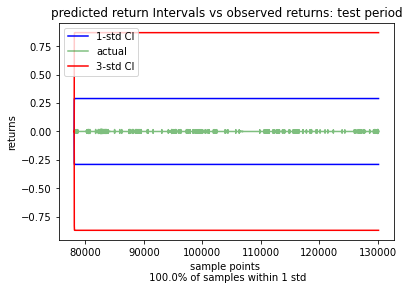

In [21]:
Garch_model.predict("test")
Garch_model.eval("test")
# failed implementation 